In [1]:
!pip install imblearn -q
!pip install keras -q
!pip install tensorflow -q
!pip install folium -q
!pip install seaborn -q

# Get the data
Same as in EDA notbook

In [2]:
import pandas as pd
import folium
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import re
import seaborn as sns
sns.set_style('white')
sns.set_color_codes("dark")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
df = pd.read_csv("../data/data_clean_new.csv", 
                          encoding='utf_8', 
                          dtype = 'unicode',
                          parse_dates = True,
                          infer_datetime_format = True,
                          low_memory=False)
df = df.drop("Unnamed: 0", axis = 1)

## Preprocess data

In [4]:
df.head(3)

,address,business_id,city,is_open,latitude,longitude,name,postal_code,review_count,stars,...,Sushi Bars,Tex-Mex,Thai,Vegan,Vegetarian,Vietnamese,Wine & Spirits,Wine Bars,Anymusic,name_length
0,30 Eglinton Avenue W,QXAEGFB4oINsVuTFxEYKFQ,Mississauga,1,43.6054989743,-79.652288909,Emerald Chinese Restaurant,L5R 3E7,128,2.5,...,0,0,0,0,0,0,0,0,False,26
1,"10110 Johnston Rd, Ste 15",gnKjwL_1w79qoiV3IC_xQQ,Charlotte,1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,...,1,0,0,0,0,0,0,0,False,27
2,2450 E Indian School Rd,1Dfx3zM-rW4n-31KeC8sJg,Phoenix,1,33.4951941,-112.0285876,Taco Bell,85016,18,3.0,...,0,1,0,0,0,0,0,0,False,9


In [5]:
df.stars.value_counts()

3.5    12833
4.0    12816
3.0     9421
4.5     5881
2.5     5080
2.0     2771
1.5      936
5.0      931
1.0      217
Name: stars, dtype: int64

In [6]:
#convert columns to the boolean datatype when we find the vlaue "True" or "False" in the column
for column in df.columns :
    if df[column][0] == 'True' or df[column][0] =='False':
        df[column] = df[column]=='True'
    #Often we find a True or False in the first line
    #This tests if the column is a boolean by using the first row for efficiency    
        
    #otherwise we test if we find a True or False value in the whole column
    elif "True" in df[column].values :
        df[column] = df[column]=='True'
    elif "False" in df[column].values :
        df[column] = df[column]=='True'

In [7]:
cuisine_type = ["American (New)","American (Traditional)","Arts & Entertainment","Asian Fusion","Bakeries","Barbeque","Bars",
"Beer","Breakfast & Brunch","Buffets","Burgers","Cafes","Canadian (New)","Caribbean","Caterers","Chicken Wings",
"Chinese","Cocktail Bars","Coffee & Tea","Comfort Food","Delis","Desserts","Diners","Ethnic Food",
"Event Planning & Services","Fast Food","Food","Food Delivery Services","French","Gastropubs","Gluten-Free",
"Greek","Grocery","Halal","Hot Dogs","Ice Cream & Frozen Yogurt","Indian","Italian","Japanese","Juice Bars & Smoothies",
"Korean","Latin American","Lounges","Mediterranean","Mexican","Middle Eastern","Nightlife","Pizza","Pubs",
"Salad","Sandwiches","Seafood","Soup","Specialty Food","Sports Bars","Steakhouses","Sushi Bars","Tex-Mex",
"Thai","Vegan","Vegetarian","Vietnamese","Wine & Spirits","Wine Bars"]

In [8]:
#The cuisine types have 1 or 0 instead of True/False
for column in df[cuisine_type] :
    df[column] = df[column]=="1"

In [9]:
df.columns

Index(['address', 'business_id', 'city', 'is_open', 'latitude', 'longitude',
       'name', 'postal_code', 'review_count', 'stars', 'state', 'Price',
       'American (New)', 'American (Traditional)', 'Arts & Entertainment',
       'Asian Fusion', 'Bakeries', 'Barbeque', 'Bars', 'Beer',
       'Breakfast & Brunch', 'Buffets', 'Burgers', 'Cafes', 'Canadian (New)',
       'Caribbean', 'Caterers', 'Chicken Wings', 'Chinese', 'Cocktail Bars',
       'Coffee & Tea', 'Comfort Food', 'Delis', 'Desserts', 'Diners',
       'Ethnic Food', 'Event Planning & Services', 'Fast Food', 'Food',
       'Food Delivery Services', 'French', 'Gastropubs', 'Gluten-Free',
       'Greek', 'Grocery', 'Halal', 'Hot Dogs', 'Ice Cream & Frozen Yogurt',
       'Indian', 'Italian', 'Japanese', 'Juice Bars & Smoothies', 'Korean',
       'Latin American', 'Lounges', 'Mediterranean', 'Mexican',
       'Middle Eastern', 'Nightlife', 'Pizza', 'Pubs', 'Salad', 'Sandwiches',
       'Seafood', 'Soup', 'Specialty Food', 'Spo

In [10]:
df['stars']=df['stars'].astype('float')
df.Price = pd.to_numeric(df.Price, errors='coerce')
df = df[np.isfinite(df['Price'])]
#df["Price"]= df["Price"].astype(int)

df["review_count"]= df["review_count"].astype(int)
df["name_length"]= df["name_length"].astype(int)
df["name"]= df["name"].astype(str)
df["address"]= df["address"].astype(str)

df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)

In [11]:
df.dtypes

address                    object
business_id                object
city                       object
is_open                    object
latitude                  float64
longitude                 float64
name                       object
postal_code                object
review_count                int32
stars                     float64
state                      object
Price                     float64
American (New)               bool
American (Traditional)       bool
Arts & Entertainment         bool
Asian Fusion                 bool
Bakeries                     bool
Barbeque                     bool
Bars                         bool
Beer                         bool
Breakfast & Brunch           bool
Buffets                      bool
Burgers                      bool
Cafes                        bool
Canadian (New)               bool
Caribbean                    bool
Caterers                     bool
Chicken Wings                bool
Chinese                      bool
Cocktail Bars 

# EDA

### Heat map
Let's start by visualizing where the restaurants in our dataset are located

In [70]:
from folium import plugins
from folium.plugins import HeatMap


# Make an empty map
m = folium.Map(location=[43,-90], tiles="Stamen Toner", zoom_start=4)

# Filter the DF for rows, then columns, then remove NaNs
heat_df = df[['latitude', 'longitude']]
heat_df = heat_df.dropna(axis=0, subset=['latitude','longitude'])

# List comprehension to make out list of lists
heat_data = [[row['latitude'],row['longitude']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(m)

# show the map
m

We can see that our data is only restaurants from North America.

### Stars on yelp

This will be the value that we want to predict, let's take a look.

In [13]:
df.stars.describe()

count    50839.000000
mean         3.447717
std          0.765024
min          1.000000
25%          3.000000
50%          3.500000
75%          4.000000
max          5.000000
Name: stars, dtype: float64

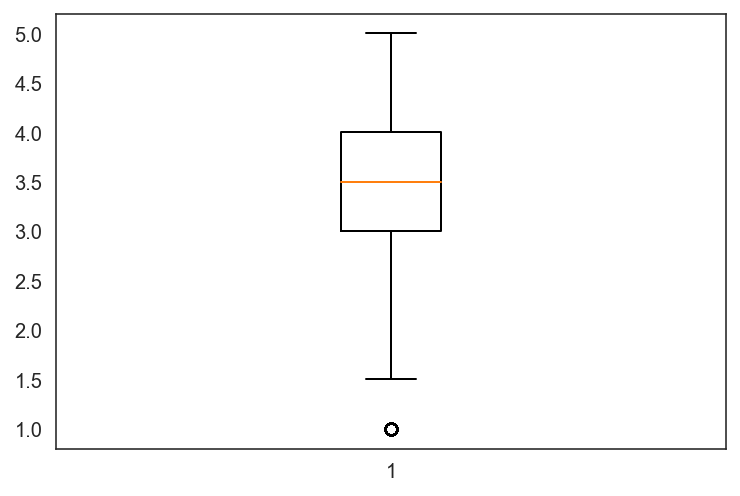

In [14]:
box_plot_data = df['stars'].astype("float")
plt.boxplot(box_plot_data)
plt.show()

We can see that we have an outlier, the 1 star ratings.

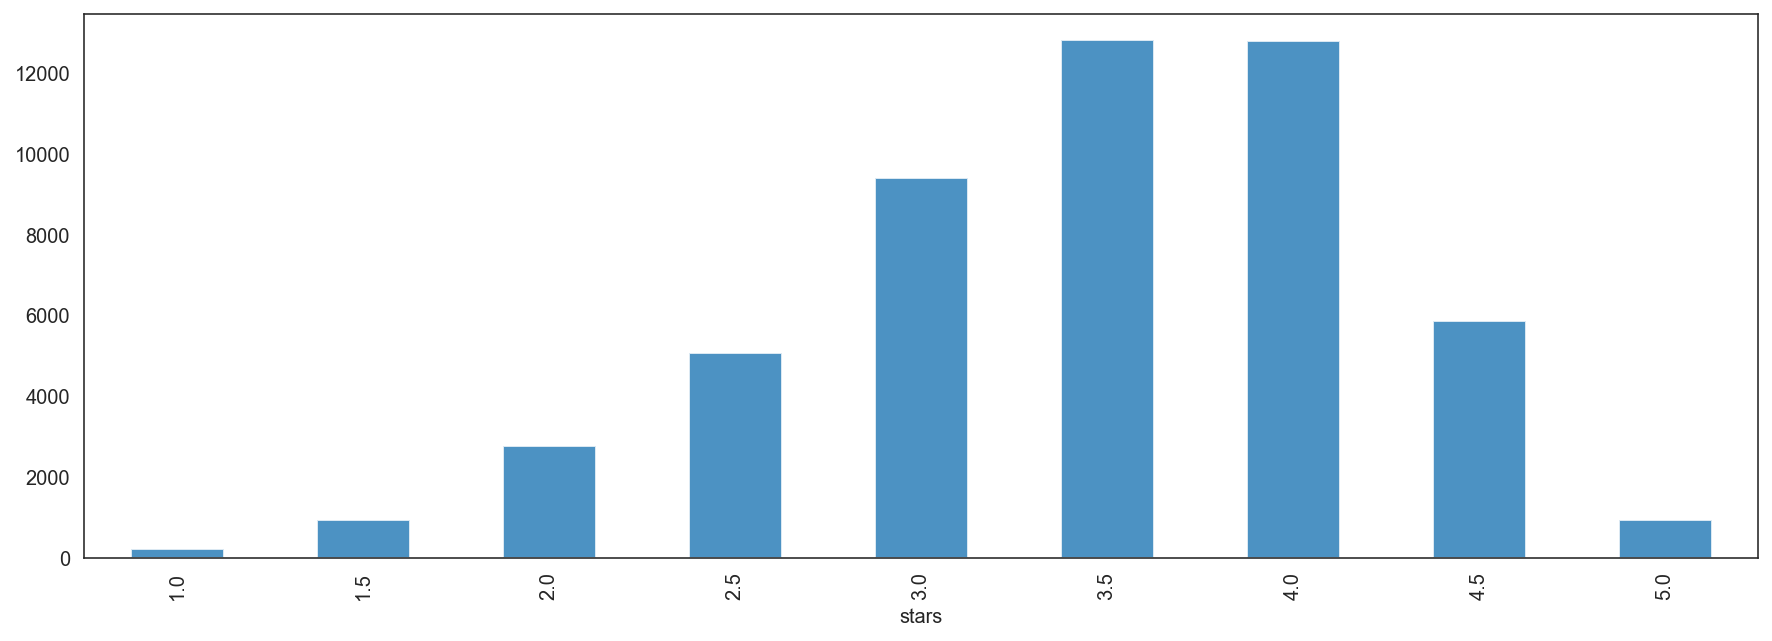

In [15]:
r1 = df[["business_id","stars"]].groupby(["stars"]).count()
r1.plot.bar(x=None, 
            y=None,
            figsize=(15,5), 
            alpha = 0.8, # make the plot 20% transparent
            legend = None, 
           )

### Price
We think that this will be an important feature so let's get som insights

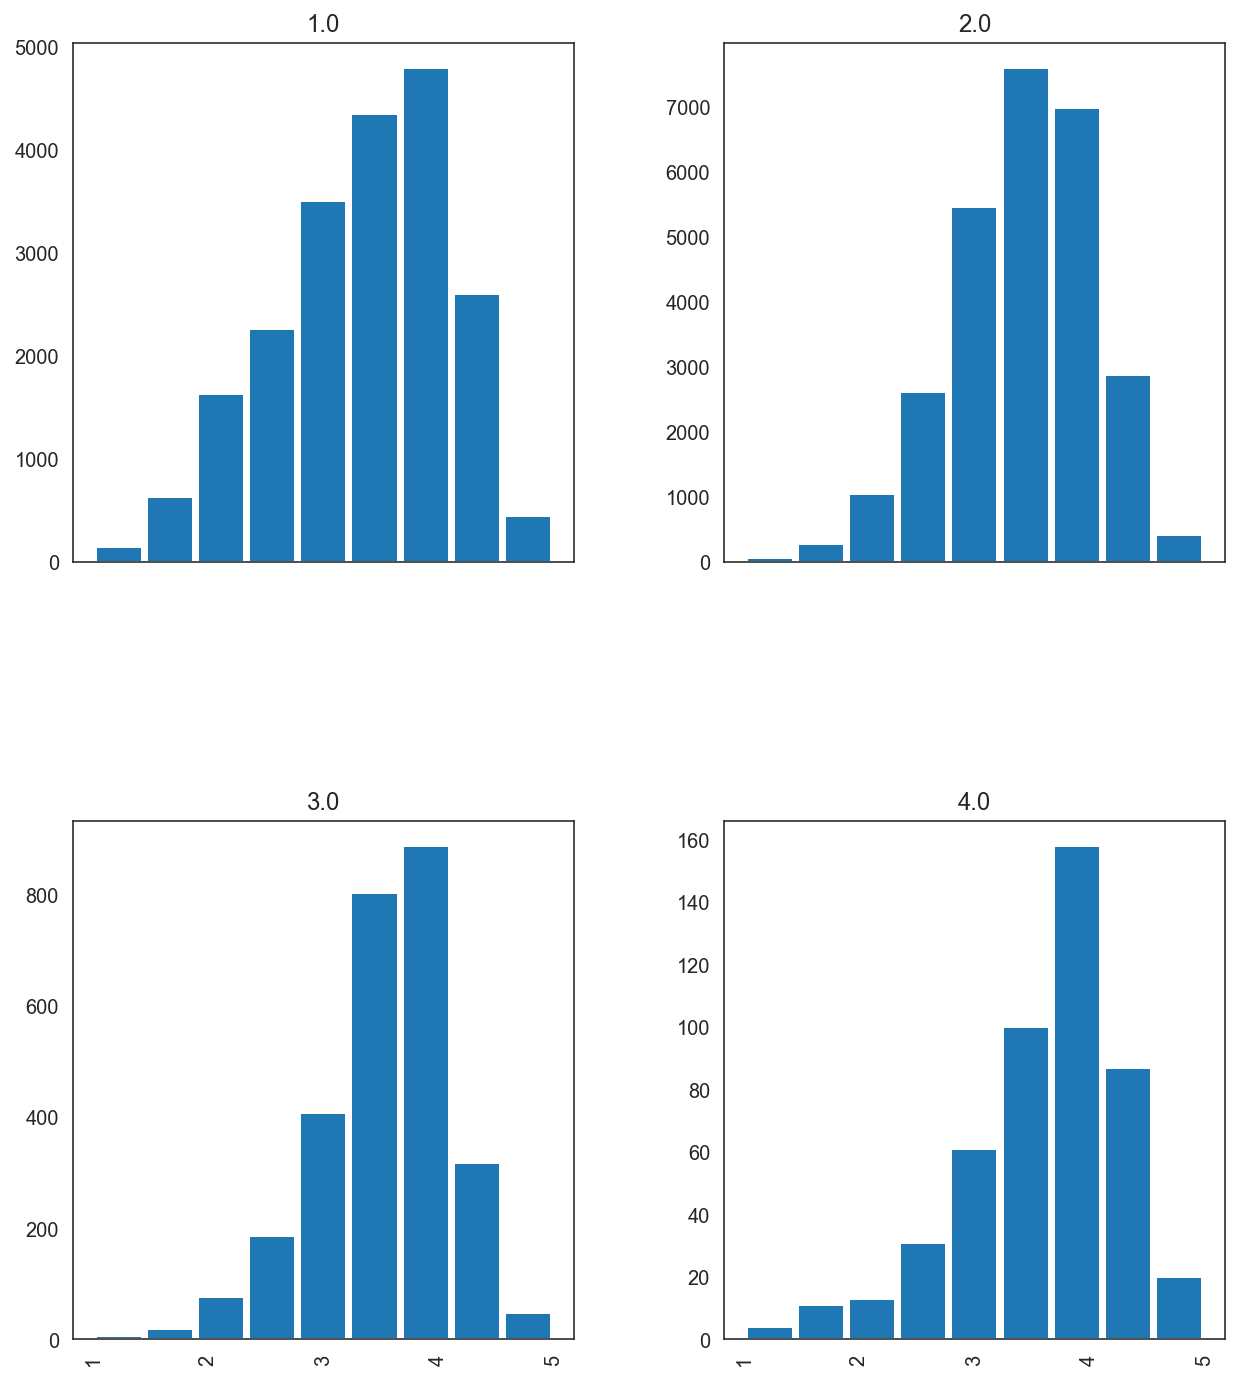

In [16]:
ax = df.hist(column="stars", by='Price',bins=9, grid=False, figsize=(10,12), layout=(2,2), sharex=True, zorder=2, rwidth=0.9)

On this graph we ploted the restaurants price classes (from 1 to 4) by stars.
We can see the different distributions of ratings depending on the price category.

### Cuisine types

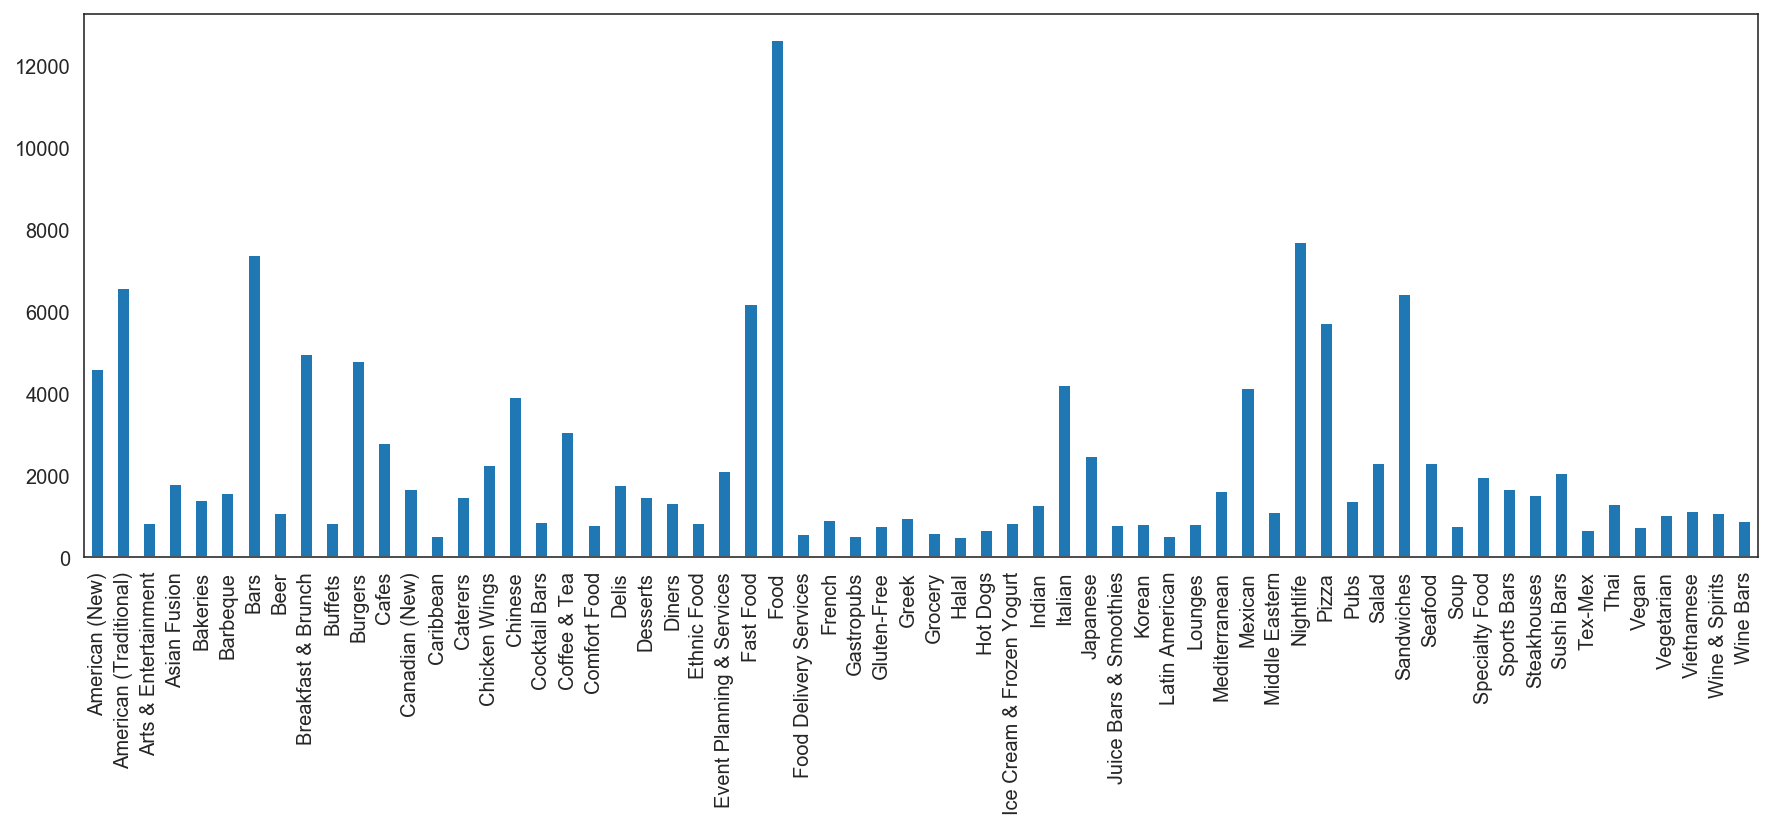

In [17]:
r2 = df[cuisine_type].sum()
r2.plot.bar(x=None, y=None, figsize = (15, 5))

Since we have a lot of cuisine type we will analyze the top 20
We also remove the first 3 cuisine types (Food, Bars and Nightlife) since we don't

In [18]:
top20_cuisines = list(df[cuisine_type].sum().sort_values(ascending=False).index[0:19])
top20_cuisines

['Food',
 'Nightlife',
 'Bars',
 'American (Traditional)',
 'Sandwiches',
 'Fast Food',
 'Pizza',
 'Breakfast & Brunch',
 'Burgers',
 'American (New)',
 'Italian',
 'Mexican',
 'Chinese',
 'Coffee & Tea',
 'Cafes',
 'Japanese',
 'Seafood',
 'Salad',
 'Chicken Wings']

In [19]:
df2 = df.copy() #create new DataFrame
st = df2.loc[:, top20_cuisines].stack()

all_ids = pd.Series(st.index.get_level_values(1), 
                          st.index.get_level_values(0),
                          name='top cuisines')[st.values]

df2 = df2.join(all_ids, how='left').dropna()

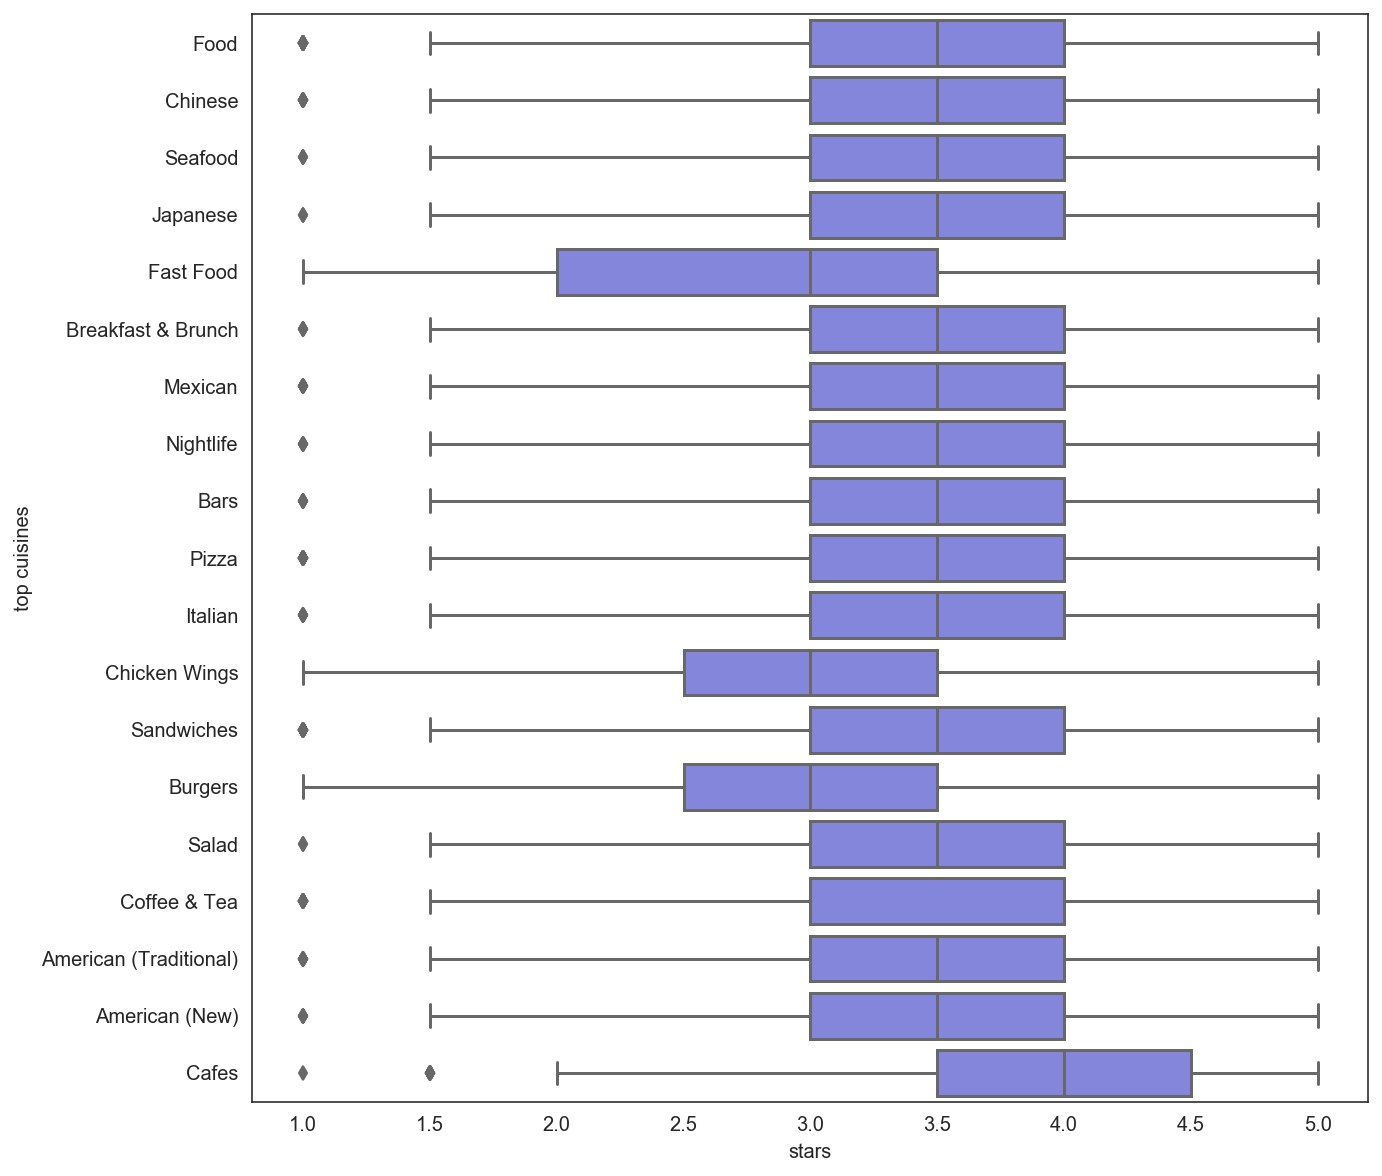

In [20]:
plt.figure(figsize = (10, 10))
sns.boxplot(data = df2[["top cuisines", "stars"]], x= "stars", y="top cuisines", color=matplotlib.colors.to_hex('#7479e8'))

We can see that Fast Food, Chicken Wings and Burgers have a lower star ratings median.
Cafes have have an above average median.

In [21]:
df2.stars = df2.stars.astype(float)
avg_ratings_cuisine = pd.DataFrame(df2.groupby("top cuisines")["stars"].mean())
avg_ratings_cuisine

,stars
top cuisines,
American (New),3.510193
American (Traditional),3.321602
Bars,3.495263
Breakfast & Brunch,3.572063
Burgers,3.038101
Cafes,3.790196
Chicken Wings,2.987556
Chinese,3.318252
Coffee & Tea,3.506048


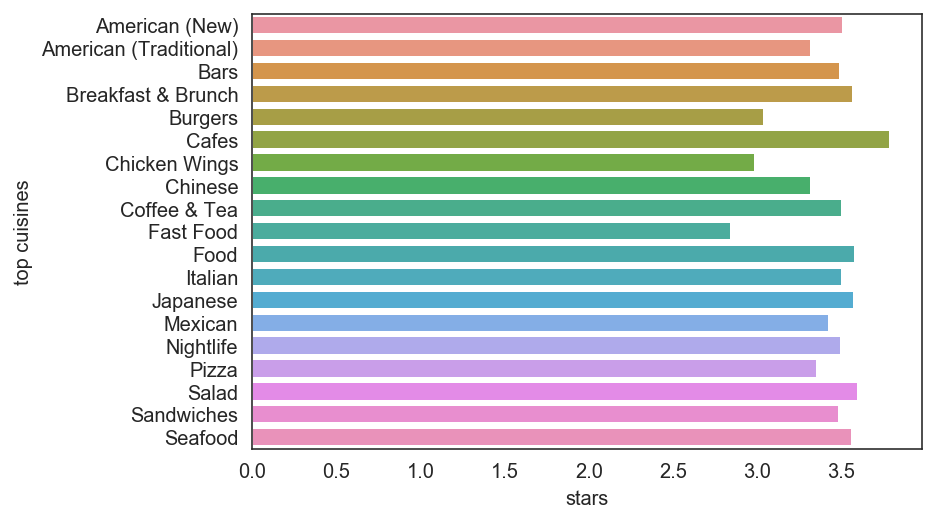

In [22]:
sns.barplot(data= avg_ratings_cuisine, x = "stars", y= avg_ratings_cuisine.index )

### Base rate
The base rate is the size of the most common class divided by the size of the dataset.
Our accuracy should be better than the default rate

In [23]:
df.stars.dtypes

dtype('float64')

In [24]:
print("The most common class for the ratings is", df["stars"].mode()[0])

baseRate = df[df["stars"] == 3.5].count()["stars"] / df["stars"].count()
print("The baserate is :", baseRate)

The most common class for the ratings is 3.5
The baserate is : 0.25228663034284704


# Preprocess data for models

The outlier we identified earlier, the 1 star rating, does not contain enough restaurants (only 216), thus we decided to drop it. We also drop string columns, which will not help in prediction (They are mainly related to geography).

In [25]:
from sklearn import preprocessing
from sklearn import utils

In [26]:
df.columns

Index(['address', 'business_id', 'city', 'is_open', 'latitude', 'longitude',
       'name', 'postal_code', 'review_count', 'stars', 'state', 'Price',
       'American (New)', 'American (Traditional)', 'Arts & Entertainment',
       'Asian Fusion', 'Bakeries', 'Barbeque', 'Bars', 'Beer',
       'Breakfast & Brunch', 'Buffets', 'Burgers', 'Cafes', 'Canadian (New)',
       'Caribbean', 'Caterers', 'Chicken Wings', 'Chinese', 'Cocktail Bars',
       'Coffee & Tea', 'Comfort Food', 'Delis', 'Desserts', 'Diners',
       'Ethnic Food', 'Event Planning & Services', 'Fast Food', 'Food',
       'Food Delivery Services', 'French', 'Gastropubs', 'Gluten-Free',
       'Greek', 'Grocery', 'Halal', 'Hot Dogs', 'Ice Cream & Frozen Yogurt',
       'Indian', 'Italian', 'Japanese', 'Juice Bars & Smoothies', 'Korean',
       'Latin American', 'Lounges', 'Mediterranean', 'Mexican',
       'Middle Eastern', 'Nightlife', 'Pizza', 'Pubs', 'Salad', 'Sandwiches',
       'Seafood', 'Soup', 'Specialty Food', 'Spo

In [27]:
X = df[df['stars'] != 1.0]
X = X.drop(['stars', "name", "address", "business_id", "city", "state", 'postal_code', 'latitude', 'longitude'], axis = 1)
y = df[df["stars"] != 1.0]["stars"]

In [28]:
y.value_counts()

3.5    12826
4.0    12809
3.0     9414
4.5     5875
2.5     5075
2.0     2762
1.5      933
5.0      929
Name: stars, dtype: int64

In [29]:
#SMOTE does not handle categorical data, we could also use SMOTE-NC


In [30]:
X.Anymusic = X.Anymusic.astype(bool)
X.is_open = X.is_open.astype(bool)

In [31]:
lab_enc = preprocessing.LabelEncoder()
encoded_y = lab_enc.fit_transform(y) #we label encode the star ratings
#X.Price = lab_enc.fit_transform(X.Price)

We divide our data into train and test.

In [32]:
from sklearn.model_selection import train_test_split, GridSearchCV
from pprint import pprint
from time import time

In [33]:
# split train/test
X_train, X_test, y_train, y_test = train_test_split(X, encoded_y, test_size=0.2, random_state=72)

Now, we decided to try two methods to fight severe class imbalance. Just downsampling is not an option (then each class will have 900 observations), thus, first we tried upsampling our train data and the we wanted to try to combine the two methods by upsampling all the classes below the mean and downsampling the classes above it. 

For upsampling we used a technique called SMOTE (**S**ynthetic **M**inority **O**ver-sampling **TE**chnique) that will synthesize new minority instances. So in our case we will basically generate "fake" restaurants based on other on the data set we have, for more details check out : http://rikunert.com/SMOTE_explained .

For downsampling we used the NearMiss methode

"first, the method calculates the distances between all instances of the majority class and the instances of the minority class. Then k instances of the majority class that have the smallest distances to those in the minority class are selected. If there are n instances in the minority class, the “nearest” method will result in k*n instances of the majority class."

source : https://towardsdatascience.com/sampling-techniques-for-extremely-imbalanced-data-part-i-under-sampling-a8dbc3d8d6d8

In [34]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

Using TensorFlow backend.


In [35]:
unique, counts = np.unique(encoded_y, return_counts=True)
dict(zip(unique, counts))

{0: 933, 1: 2762, 2: 5075, 3: 9414, 4: 12826, 5: 12809, 6: 5875, 7: 929}

In [36]:
#upsamples all the train data
X_resampled, y_resampled = SMOTE(random_state = 72).fit_resample(X_train, y_train)

In [37]:
med_cl_cnt= int(pd.Series(y_train).value_counts().median()) # median of obs over classes
med_cl_cnt

4379

In [38]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 736, 1: 2202, 2: 4056, 3: 7539, 4: 10268, 5: 10266, 6: 4702, 7: 729}

In [39]:
#downsamples and upsamples the train data (based on median)
X_resampled2, y_resampled2 = NearMiss(sampling_strategy = {3:med_cl_cnt, 4:med_cl_cnt, 5:med_cl_cnt, 6:med_cl_cnt}).fit_resample(X_train, y_train) #downsampling
X_resampled2, y_resampled2 = SMOTE(random_state = 72, sampling_strategy = {7:med_cl_cnt, 0:med_cl_cnt, 1:med_cl_cnt, 2:med_cl_cnt}).fit_resample(X_resampled2, y_resampled2) # upsampling

In [40]:
unique, counts = np.unique(y_resampled2, return_counts=True)
dict(zip(unique, counts))

{0: 4379, 1: 4379, 2: 4379, 3: 4379, 4: 4379, 5: 4379, 6: 4379, 7: 4379}

Specify parameters values for grid search: 

In [41]:
parametersRF = {
    'n_estimators': (100,200,300),
    'max_depth': (10,20,30)
}
parametersLR = {
    'C': (0.1, 1,100),
    'solver': (['saga','lbfgs'])
}
parametersNN = {
    'epochs': ([10, 100]),
    'batch_size': ([20,30])
}

# Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

We tried three different samples of data: normal, upsampled, upsampled+downsampled 

We found that for logistic regression the best result is produced with the normal data

In [44]:
# decomment, if need to run best model with other params 
LR = LogisticRegression(solver='lbfgs',C=0.1, max_iter=2000, multi_class = "auto")
LR.fit(X_train, y_train)

C:\Users\David\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [45]:
if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(LR, parametersLR, cv=2,
                               n_jobs=-1, verbose=1,scoring='accuracy')

    print("Performing grid search...")
    #print("pipeline:", [name for name, _ in pipeline2.steps])
    print("parameters:")
    pprint(parametersLR)
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score for Logistic Regression: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parametersLR.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Performing grid search...
parameters:
{'C': (0.1, 1, 100), 'solver': ['saga', 'lbfgs']}
Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  1.1min remaining:   13.6s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.1min finished


done in 112.545s

Best score for Logistic Regression: 0.303
Best parameters set:
	C: 0.1
	solver: 'lbfgs'


C:\Users\David\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


The best model according to gridsearch is the one we tested at the beginning with lbfgs solver and C equal to 0.1

In [46]:
# train accuracy
LR.score(X_train, y_train)

0.3085337547533212

In [47]:
# test accuracy
LR.score(X_test, y_test)

0.2973827160493827

In [48]:
from sklearn.metrics import classification_report
target_names = ["1.5","2","2.5","3","3.5","4","4.5","5"]

print(classification_report(y_test, LR.predict(X_test), target_names= target_names))

              precision    recall  f1-score   support

         1.5       0.00      0.00      0.00       197
           2       0.27      0.22      0.24       560
         2.5       0.22      0.05      0.09      1019
           3       0.26      0.15      0.19      1875
         3.5       0.29      0.45      0.35      2558
           4       0.32      0.53      0.40      2543
         4.5       0.44      0.06      0.11      1173
           5       0.00      0.00      0.00       200

    accuracy                           0.30     10125
   macro avg       0.22      0.18      0.17     10125
weighted avg       0.29      0.30      0.26     10125



C:\Users\David\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Our test accuracy is above the baserate but it isn't really a good result since we cannot predict 1.5 and 5 stars.

# Random Forest Classifier

Here we will try both data samples, but still we believe that sticking to one method of upsampling is better (at least more common).

In [49]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
MAE = make_scorer(mean_absolute_error)
folds = 3

In [50]:
clf = RandomForestClassifier(n_estimators = 200,max_depth = 30)
clf.fit(X_resampled, y_resampled)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [51]:
if __name__ == "__main__": # just for multiprocessing purposes
    grid_search = GridSearchCV(clf, parametersRF, cv=3,
                               n_jobs=-1, verbose=1,scoring='accuracy')

    print("Performing grid search...")
    #print("Random Forest:", [name for name, _ in clf.steps])
    print("parameters:")
    pprint(parametersRF)
    t0 = time()
    grid_search.fit(X_resampled2, y_resampled2)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score for Random Forest: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parametersRF.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
parameters:
{'max_depth': (10, 20, 30), 'n_estimators': (100, 200, 300)}
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   40.2s finished


done in 49.294s

Best score for Random Forest: 0.401
Best parameters set:
	max_depth: 30
	n_estimators: 200


In [52]:
clf = RandomForestClassifier(n_estimators = 300,max_depth = 30)
clf.fit(X_resampled, y_resampled)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [53]:
clf2 = RandomForestClassifier(n_estimators = 300,max_depth = 30)
clf2.fit(X_resampled2, y_resampled2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [54]:
print("Train accuracy :", clf.score(X_resampled, y_resampled))
print("Test accuracy :", clf.score(X_test, y_test))

Train accuracy : 0.8866867939228672
Test accuracy : 0.2854320987654321


In [55]:
print("Train acc upsample + downsample :", clf2.score(X_resampled2, y_resampled2))
print("Test acc upsample + downsample :", clf2.score(X_test, y_test))

Train acc upsample + downsample : 0.853505366522037
Test acc upsample + downsample : 0.21175308641975307


Report for upsampling:

In [56]:
print(classification_report(y_test, clf.predict(X_test), target_names= target_names))

              precision    recall  f1-score   support

         1.5       0.21      0.33      0.26       197
           2       0.20      0.22      0.21       560
         2.5       0.20      0.17      0.19      1019
           3       0.26      0.22      0.24      1875
         3.5       0.32      0.36      0.34      2558
           4       0.35      0.36      0.35      2543
         4.5       0.27      0.22      0.24      1173
           5       0.09      0.14      0.11       200

    accuracy                           0.29     10125
   macro avg       0.24      0.25      0.24     10125
weighted avg       0.29      0.29      0.28     10125



Report for upsampling + downsampling:

In [57]:
print(classification_report(y_test, clf2.predict(X_test), target_names= target_names)) 

              precision    recall  f1-score   support

         1.5       0.18      0.29      0.22       197
           2       0.19      0.19      0.19       560
         2.5       0.15      0.23      0.18      1019
           3       0.26      0.17      0.21      1875
         3.5       0.27      0.17      0.21      2558
           4       0.27      0.15      0.19      2543
         4.5       0.18      0.50      0.27      1173
           5       0.10      0.14      0.12       200

    accuracy                           0.21     10125
   macro avg       0.20      0.23      0.20     10125
weighted avg       0.24      0.21      0.21     10125



For random forest upsampling data produces the best result

At the end, we would like to use mean absolute error as a performance metric for our models, because predicting rating of the restaurant is a classification with ordinal variable. Thus, misclassification of 0.5 star is better than 1.5 stars.

In [58]:
MAE_RF = cross_val_score(clf,
    X_resampled,
    y_resampled,
    cv=folds,
    scoring=MAE)

In [60]:
print("Random forest MAE :", np.mean(MAE_RF))

Random forest MAE : 0.7039451011343688


[0.         0.29800039 0.06820441 0.01515998 0.01201516 0.00526027
 0.00802179 0.00507183 0.00744214 0.00556076 0.00220836 0.01545872
 0.00509805 0.01657808 0.00858648 0.00836663 0.0033357  0.00407641
 0.00960738 0.00715187 0.00270939 0.00863415 0.00569523 0.0076955
 0.00604288 0.00678697 0.00228925 0.00656537 0.02955366 0.01219629
 0.0034931  0.00437711 0.00295202 0.0050741  0.00540909 0.00348327
 0.00382619 0.00517109 0.00440155 0.00645447 0.01103626 0.00710901
 0.00407904 0.00457244 0.0036369  0.00334613 0.00613572 0.01005864
 0.00573326 0.00647433 0.0103302  0.00414828 0.00968939 0.01475103
 0.00954069 0.00445216 0.00615938 0.00347768 0.00608864 0.00646778
 0.00301797 0.00558962 0.00402245 0.00481717 0.00558759 0.00218616
 0.00257155 0.0045649  0.19234052]


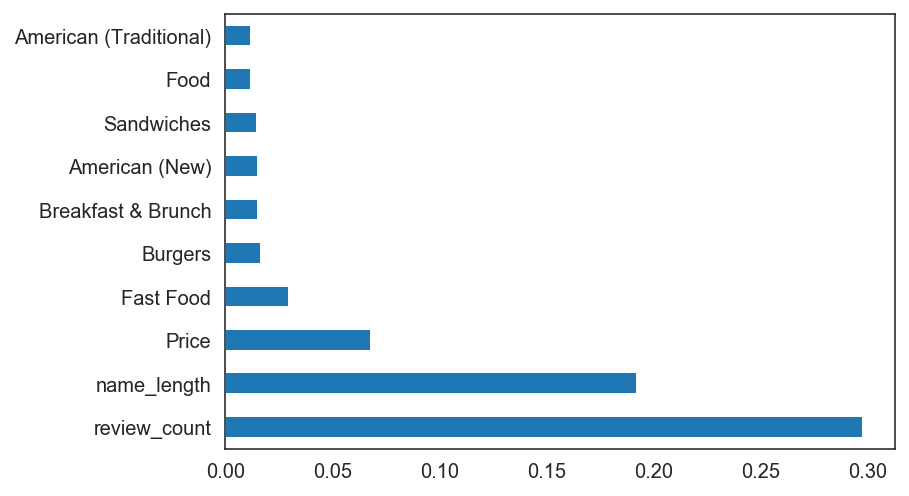

In [61]:
model = ExtraTreesClassifier(n_estimators=100)
model.fit(X_resampled, y_resampled)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

# Neural network

Here we are implementing neural network with basic architecture on not sampled data. 

In [62]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras import optimizers
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
np.random.seed(1143)

In [63]:
def model_NN():
    model = Sequential()
    model.add(Dense(512, input_shape=(69,)))
    model.add(Activation('relu')) # An "activation" is just a non-linear function applied to the output
                              # of the layer above. Here, with a "rectified linear unit"
                              # we clamp all values below 0 to 0. 
            
    model.add(Dropout(0.2))   # Dropout helps protect the model from memorizing or "overfitting" the training data
    model.add(Dense(8))
    model.add(Activation('softmax')) # This special "softmax" activation among other things,
                                 # ensures the output is a valid probaility distribution, that is
                                 # that its values are all non-negative and sum to 1.
    #optimizer = optimizers.Adam(lr=0.01, decay=1e-6)
    optimizer = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [64]:
model = KerasClassifier(build_fn= model_NN, epochs=100, batch_size=10, verbose=0)

In [65]:
X = df[df["stars"] != 1]
X = X.drop(['stars', "name", "address", "business_id", "city", "state", 'postal_code', "longitude", "latitude"], axis = 1)
y = df[df["stars"] !=1]["stars"]

In [66]:
#nb_classes = len(y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)


In [67]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=8)
y_test = to_categorical(y_test, num_classes=8)

In [68]:
model_hist = model.fit(X_train, y_train,
                       batch_size=64, epochs=10,
                       verbose=1, validation_split=0.2)

Train on 32398 samples, validate on 8100 samples
Epoch 1/10
32398/32398 [==============================] - 1s 36us/step - loss: 1.6791 - accuracy: 0.4296 - val_loss: 1.1909 - val_accuracy: 0.4381
Epoch 2/10
32398/32398 [==============================] - 1s 34us/step - loss: 1.1915 - accuracy: 0.4320 - val_loss: 1.1761 - val_accuracy: 0.3926
Epoch 3/10
32398/32398 [==============================] - 1s 35us/step - loss: 1.1698 - accuracy: 0.4339 - val_loss: 1.1749 - val_accuracy: 0.4391
Epoch 4/10
32398/32398 [==============================] - 1s 37us/step - loss: 1.1637 - accuracy: 0.4388 - val_loss: 1.1567 - val_accuracy: 0.4401
Epoch 5/10
32398/32398 [==============================] - 1s 33us/step - loss: 1.1609 - accuracy: 0.4353 - val_loss: 1.1558 - val_accuracy: 0.4399
Epoch 6/10
32398/32398 [==============================] - 1s 34us/step - loss: 1.1573 - accuracy: 0.4378 - val_loss: 1.1648 - val_accuracy: 0.4381
Epoch 7/10
32398/32398 [==============================] - 1s 33us/ste

In [69]:
score = model.score(X_test, y_test, verbose=0)
score

0.43614813685417175

## Conclusion

We conducted good EDA for YELP restaurant data and tested three different models to predict the star rating.

The best model in terms of stars prediction turned out to be neural network with test accuracy equal to 0.43.

Thus, we suggest our friends use this model to understand, how their current restaurant performance will behave in America and estimate their rating among clients.